# Implementation of SVM

Support Vector Machine (SVMs) are supervised machine learning algorithms that classify data by finding an optimat line (or hyperplane) that maximses the distance betweeneach class in an N-dimensional space.

## Install required packages

In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

## Imports

Import any packages required for this project.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

## Variables

Variables required throughout the whole notebook.

In [3]:
data_folder = "../../../data"
final_data_folder = f"{data_folder}/final"

data_csv = f"{final_data_folder}/data.csv"

## Explanation of notebook structure

1. First, we will perform some initial data exploratory analysis.
2. Then, we will attempt to implement an SVM using sklearn.

## Exploratory Data Analysis (EDA)

Perform a little bit of exploratory data analysis.

In [4]:
df = pd.read_csv(data_csv)

print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Dataset info:")
display(df.info())

Dataset shape: (219, 54)
Column names: ['id', 'date_published', 'accident_datetime', 'accident_severity', 'total_injured', 'city', 'street', 'accident_time_category', 'driver_under_18', 'driver_18_to_24', 'driver_25_to_49', 'driver_50_to_64', 'driver_65_plus', 'driver_age_unknown', 'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49', 'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown', 'driver_male', 'driver_female', 'driver_gender_unknown', 'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total', 'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike', 'vehicle_car', 'vehicle_van', 'vehicle_bus', 'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle', 'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus', 'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', 'is_school_day_mt', 'street_type', 'region', 'temperature_max', 'temperature_mi

None

### Outliers

Data collection happened between 2024-2025. However, we noticed some news articles report accidents that have happened some years back.

These accidents could have happened under different conditions (different road conditions, traffic situations, etcetera) so we consider these accidents as outliers and will filter them out.

Accidents by Year:


accident_datetime
2006      1
2017      1
2018      1
2020      1
2022      2
2023      2
2024     23
2025    188
Name: count, dtype: int64

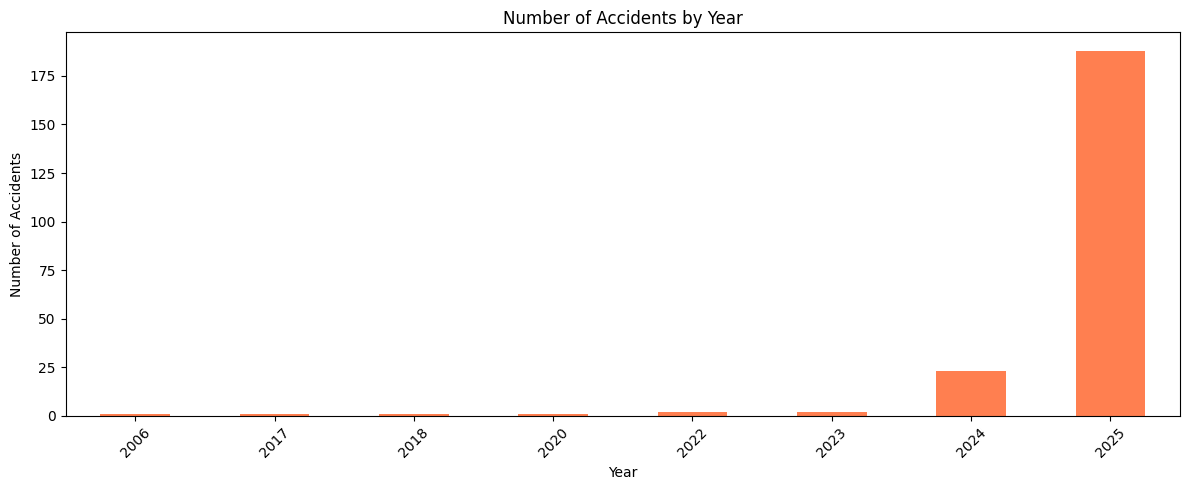

In [5]:
df["accident_datetime"] = pd.to_datetime(df["accident_datetime"])

accidents_by_year = df["accident_datetime"].dt.year.value_counts().sort_index()

print("Accidents by Year:")
display(accidents_by_year)

plt.figure(figsize=(12, 5))
accidents_by_year.plot(kind='bar', color='coral')
plt.title('Number of Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's filter out accidents that happened before 2024.

In [6]:
count_before = len(df)
df = df[df["accident_datetime"] >= "2024-01-01"]
count_after = len(df)

print(f"Removed {count_before - count_after} outliers")
print(f"Dataset shape after removing outliers: {df.shape}")

Removed 8 outliers
Dataset shape after removing outliers: (211, 54)


### Distribution of `accident_severity` column

In [7]:
severity_counts = df["accident_severity"].value_counts()

print(severity_counts)

accident_severity
grievious      85
serious        74
fatal          28
not injured    17
slight          7
Name: count, dtype: int64


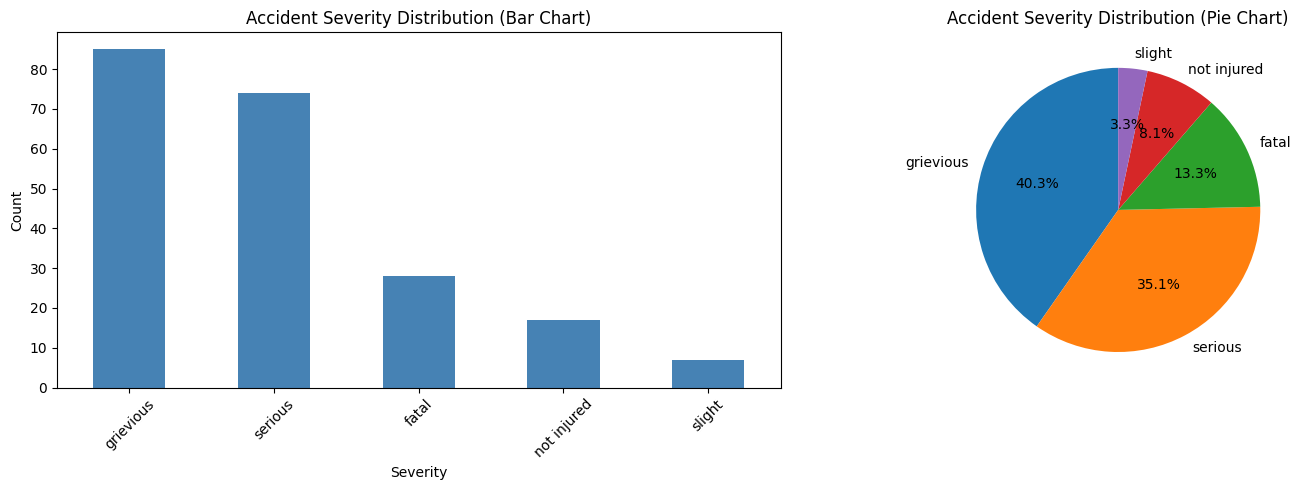

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# bar plot
severity_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Accident Severity Distribution (Bar Chart)')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# pie chart
axes[1].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Accident Severity Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

The distribution of the `accident_severity` target variable is highly imbalanced, with certain classes containing very few samples. Given the limited dataset size (219 instances), this results in insufficient per-class representation for reliable multi-class learning.

To tackle this issue, the problem is reformulated as a binary classification task, where we attempt to classify fatal vs non fatal accidents.

In [9]:
fatal_buckets = {"fatal"}
non_fatal_buckets = {"grievious", "serious", "not injured", "slight"}

df["is_fatal"] = df["accident_severity"].map(lambda x: 0 if x in non_fatal_buckets else 1)

summarised_fatality = df["is_fatal"].value_counts()
print(summarised_fatality)

print(f"Dataset info:")
display(df.info())

is_fatal
0    183
1     28
Name: count, dtype: int64
Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 8 to 218
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          211 non-null    object        
 1   date_published              211 non-null    object        
 2   accident_datetime           211 non-null    datetime64[ns]
 3   accident_severity           211 non-null    object        
 4   total_injured               211 non-null    int64         
 5   city                        211 non-null    object        
 6   street                      211 non-null    object        
 7   accident_time_category      211 non-null    object        
 8   driver_under_18             211 non-null    bool          
 9   driver_18_to_24             211 non-null    bool          
 10  driver_25_to_49             211 non-null    bool          
 

None

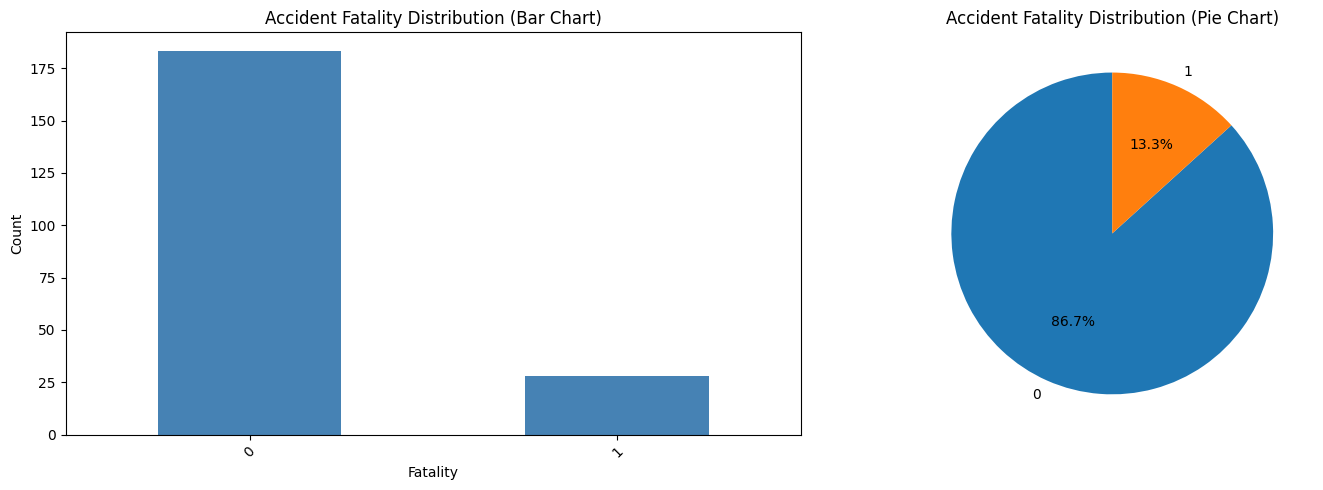

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# bar plot
summarised_fatality.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Accident Fatality Distribution (Bar Chart)')
axes[0].set_xlabel('Fatality')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# pie chart
axes[1].pie(summarised_fatality.values, labels=summarised_fatality.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Accident Fatality Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### Analysis on all columns

Compare each of the columns to the target `is_fatal` classifier.

#### `accident_time_category` column

                        non_fatal  fatal  total  fatal_rate
accident_time_category                                     
afternoon                      56     11     67    0.164179
early_morning                  25      0     25    0.000000
evening                        19      4     23    0.173913
late_evening                    9      4     13    0.307692
morning                        41      4     45    0.088889
night                          33      5     38    0.131579


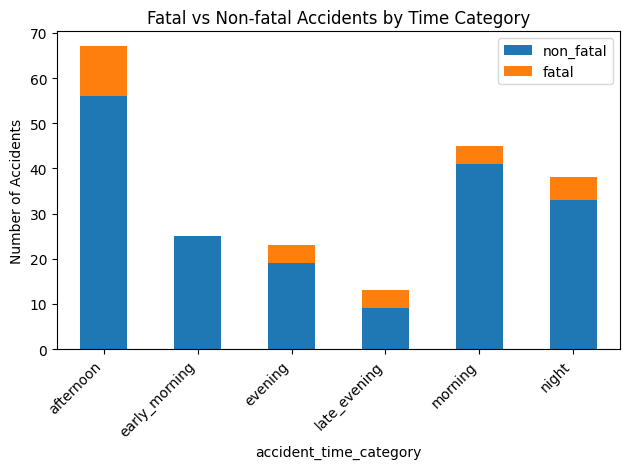

In [11]:
accident_time_category_stats = (
    df
    .groupby("accident_time_category")["is_fatal"]
    .value_counts()
    .unstack(fill_value=0)
)

accident_time_category_stats.columns = ["non_fatal", "fatal"]

accident_time_category_stats["total"] = accident_time_category_stats["non_fatal"] + accident_time_category_stats["fatal"]
accident_time_category_stats["fatal_rate"] = accident_time_category_stats["fatal"] / accident_time_category_stats["total"]

print(accident_time_category_stats)

accident_time_category_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Time Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Many fatal accidents seem to be reported in the afternoon. No fatal accidents have been reported in the early morning.

#### (Categorical) Age Columns

True/False columns denoting whether a particular age group was involved in an accident.

**Important**: Since some accidents involve multiple drivers, these columns are not one-hot encoded but two different age buckets can be both marked as True for one accident.

                    total  fatal  fatality_rate  non_fatal
age_bucket                                                
driver_18_to_24        40     10       0.250000         30
driver_under_18         8      2       0.250000          6
driver_25_to_49       119     14       0.117647        105
driver_50_to_64        51      6       0.117647         45
driver_65_plus         39      4       0.102564         35
driver_age_unknown     34      2       0.058824         32


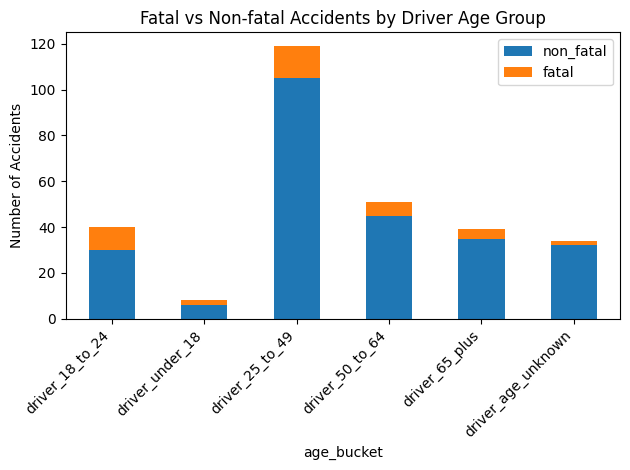

In [12]:
categorial_age_buckets = [
    "driver_under_18",
    "driver_18_to_24",
    "driver_25_to_49",
    "driver_50_to_64",
    "driver_65_plus",
    "driver_age_unknown",
]

age_df = df.melt(
    id_vars=["is_fatal"],
    value_vars=categorial_age_buckets,
    var_name="age_bucket",
    value_name="present"
)

# Keep only accidents where that age bucket is present
age_df = age_df[age_df["present"] == 1]

age_stats = (
    age_df
    .groupby("age_bucket")["is_fatal"]
    .agg(
        total="count",
        fatal="sum",
        fatality_rate="mean"
    )
    .sort_values("fatality_rate", ascending=False)
)

age_stats["non_fatal"] = age_stats["total"] - age_stats["fatal"]
print(age_stats)

age_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Driver Age Group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### (Numerical) Age Columns

Count of drivers involved for a particular age group per accident.

Stats: num_drivers_under_18
                      accidents  fatal  fatality_rate
num_drivers_under_18                                 
1                             8      2           0.25


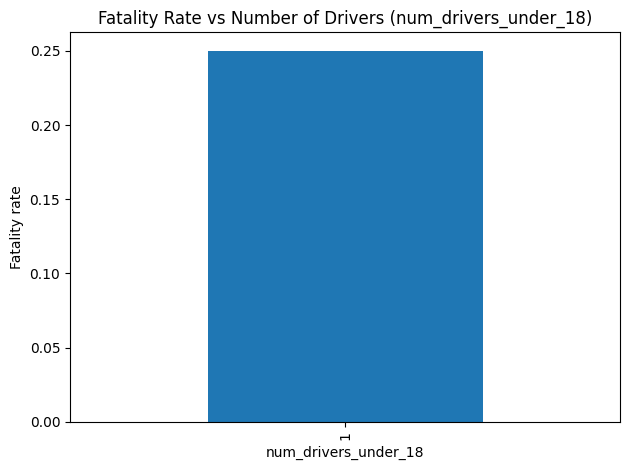

Stats: num_drivers_18_to_24
                      accidents  fatal  fatality_rate
num_drivers_18_to_24                                 
1                            36      8       0.222222
2                             4      2       0.500000


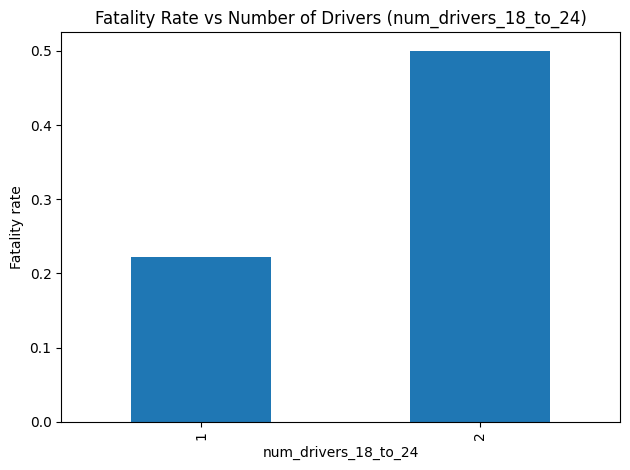

Stats: num_drivers_25_to_49
                      accidents  fatal  fatality_rate
num_drivers_25_to_49                                 
1                            84     11       0.130952
2                            34      3       0.088235
4                             1      0       0.000000


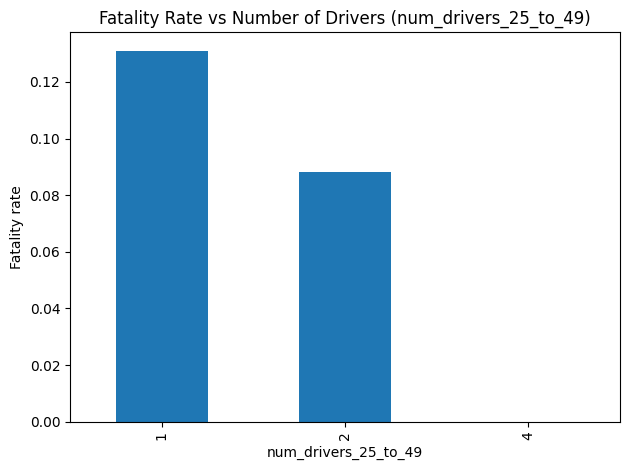

Stats: num_drivers_50_to_64
                      accidents  fatal  fatality_rate
num_drivers_50_to_64                                 
1                            45      5       0.111111
2                             6      1       0.166667


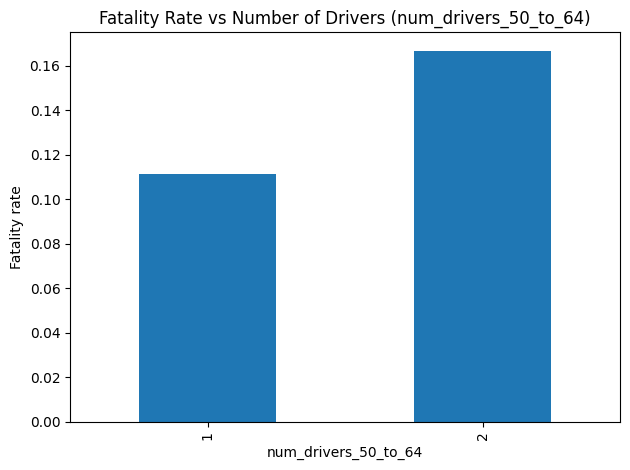

Stats: num_drivers_65_plus
                     accidents  fatal  fatality_rate
num_drivers_65_plus                                 
1                           34      3       0.088235
2                            5      1       0.200000


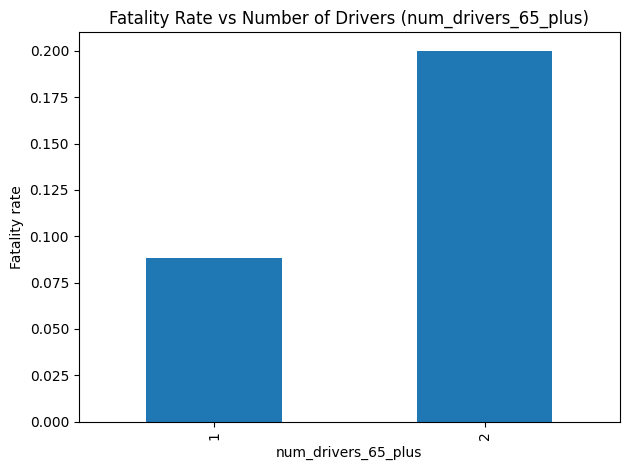

Stats: num_drivers_age_unknown
                         accidents  fatal  fatality_rate
num_drivers_age_unknown                                 
1                               27      2       0.074074
2                                7      0       0.000000


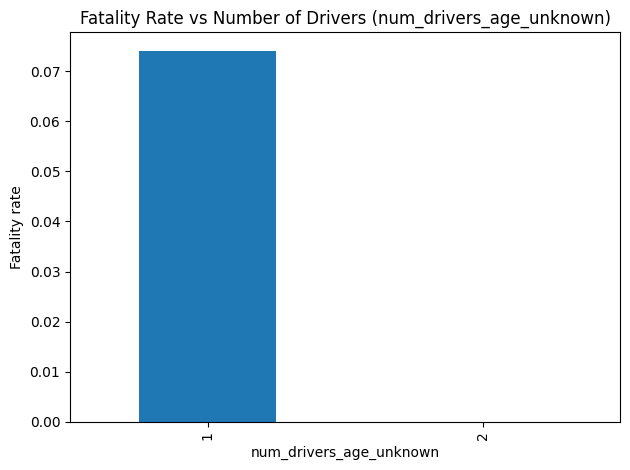

In [13]:
numerical_age_buckets = [
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
]

for col in numerical_age_buckets:
    filtered = df[df[col] > 0]

    if filtered.empty:
        continue # nothing to report

    numeric_age_stats = (
        filtered
        .groupby(col)["is_fatal"]
        .agg(
            accidents="count",
            fatal="sum",
            fatality_rate="mean"
        )
    )

    print(f"Stats: {col}")
    print(numeric_age_stats)

    numeric_age_stats["fatality_rate"].plot(kind="bar")
    plt.title(f"Fatality Rate vs Number of Drivers ({col})")
    plt.ylabel("Fatality rate")
    plt.tight_layout()
    plt.show()

An interesting observation is that fatality rate seems to be high for lower age brackets.

#### (Categorical) Gender Columns

True/False columns denoting whether a particular gender group was involved in an accident.

**Important**: Since some accidents involve multiple drivers, these columns are not one-hot encoded but two different gender buckets can be both marked as True for one accident.

                       total  fatal  fatality_rate  non_fatal
gender_bucket                                                
driver_gender_unknown     42      7       0.166667         35
driver_male              173     25       0.144509        148
driver_female             61      4       0.065574         57


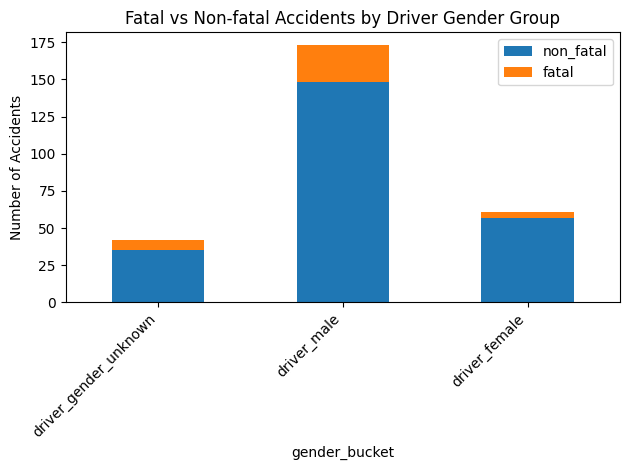

In [14]:
categorial_gender_buckets = [
    "driver_male",
    "driver_female",
    "driver_gender_unknown",
]

gender_df = df.melt(
    id_vars=["is_fatal"],
    value_vars=categorial_gender_buckets,
    var_name="gender_bucket",
    value_name="present"
)

# Keep only accidents where that gender bucket is present
gender_df = gender_df[gender_df["present"] == 1]

gender_stats = (
    gender_df
    .groupby("gender_bucket")["is_fatal"]
    .agg(
        total="count",
        fatal="sum",
        fatality_rate="mean"
    )
    .sort_values("fatality_rate", ascending=False)
)

gender_stats["non_fatal"] = gender_stats["total"] - gender_stats["fatal"]
print(gender_stats)

gender_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Driver Gender Group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### (Numerical) Gender Columns

Count of drivers involved for a particular gender group per accident.

Stats: num_drivers_male
                  accidents  fatal  fatality_rate
num_drivers_male                                 
1                       120     20       0.166667
2                        48      3       0.062500
3                         4      2       0.500000
4                         1      0       0.000000


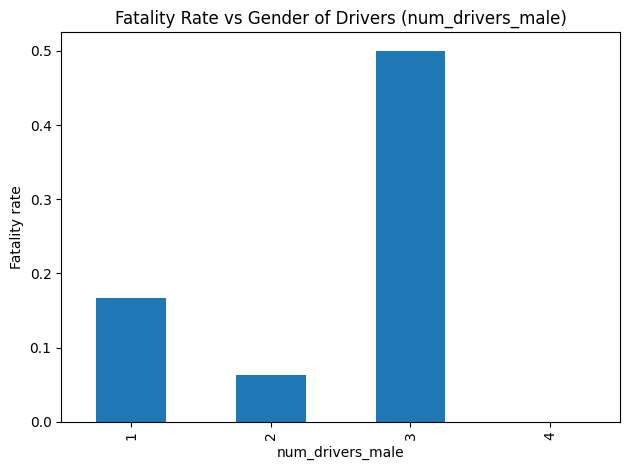

Stats: num_drivers_female
                    accidents  fatal  fatality_rate
num_drivers_female                                 
1                          55      2       0.036364
2                           6      2       0.333333


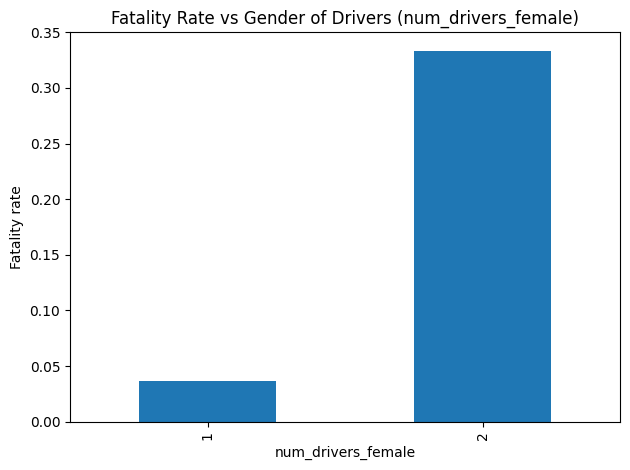

Stats: num_drivers_gender_unknown
                            accidents  fatal  fatality_rate
num_drivers_gender_unknown                                 
1                                  33      7       0.212121
2                                   9      0       0.000000


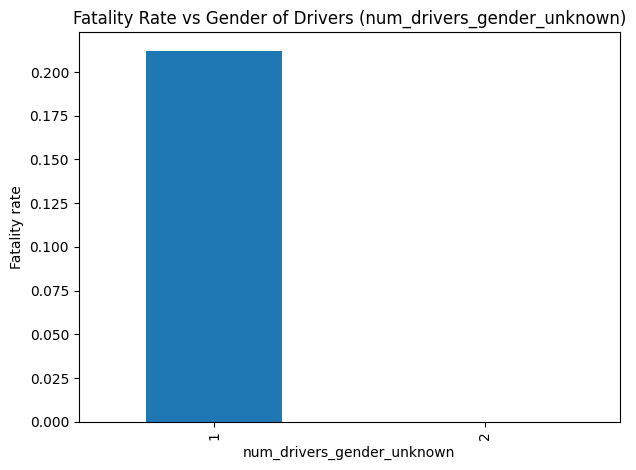

In [15]:
numerical_gender_buckets = [
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
]

for col in numerical_gender_buckets:
    filtered = df[df[col] > 0]

    if filtered.empty:
        continue # nothing to report

    numeric_gender_stats = (
        filtered
        .groupby(col)["is_fatal"]
        .agg(
            accidents="count",
            fatal="sum",
            fatality_rate="mean"
        )
    )

    print(f"Stats: {col}")
    print(numeric_gender_stats)

    numeric_gender_stats["fatality_rate"].plot(kind="bar")
    plt.title(f"Fatality Rate vs Gender of Drivers ({col})")
    plt.ylabel("Fatality rate")
    plt.tight_layout()
    plt.show()

#### (Categorical) Vehicle Columns

True/False columns denoting whether a particular vehicle was involved in an accident.

**Important**: Since some accidents involve multiple drivers, these columns are not one-hot encoded but two different vehicles can be both marked as True for one accident.

                    total  fatal  fatality_rate  non_fatal
vehicle_bucket                                            
vehicle_bus            11      3       0.272727          8
vehicle_bicycle         7      1       0.142857          6
vehicle_van            28      4       0.142857         24
vehicle_motorbike     101     12       0.118812         89
vehicle_car           154     15       0.097403        139
vehicle_pedestrian     13      1       0.076923         12
vehicle_unknown         2      0       0.000000          2


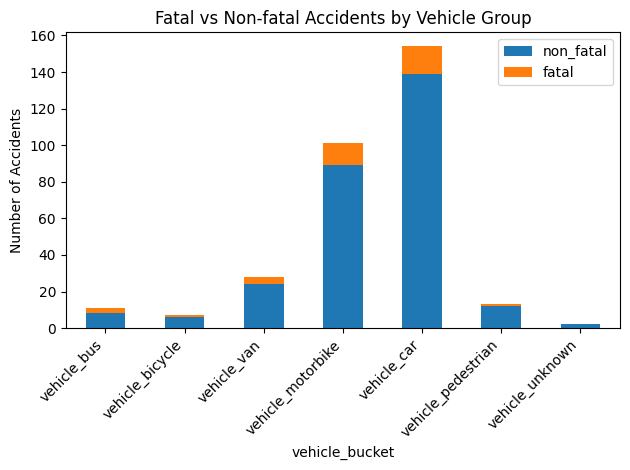

In [16]:
categorial_vehicle_buckets = [
    "vehicle_unknown",
    "vehicle_pedestrian",
    "vehicle_bicycle",
    "vehicle_motorbike",
    "vehicle_car",
    "vehicle_van",
    "vehicle_bus",
]

vehicle_df = df.melt(
    id_vars=["is_fatal"],
    value_vars=categorial_vehicle_buckets,
    var_name="vehicle_bucket",
    value_name="present"
)

# Keep only accidents where that vehicle bucket is present
vehicle_df = vehicle_df[vehicle_df["present"] == 1]

vehicle_stats = (
    vehicle_df
    .groupby("vehicle_bucket")["is_fatal"]
    .agg(
        total="count",
        fatal="sum",
        fatality_rate="mean"
    )
    .sort_values("fatality_rate", ascending=False)
)

vehicle_stats["non_fatal"] = vehicle_stats["total"] - vehicle_stats["fatal"]
print(vehicle_stats)

vehicle_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Vehicle Group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### (Numerical) Vehicle Columns

Count of vehicles involved in an accident.

Stats: num_vehicle_unknown
                     accidents  fatal  fatality_rate
num_vehicle_unknown                                 
1                            2      0            0.0


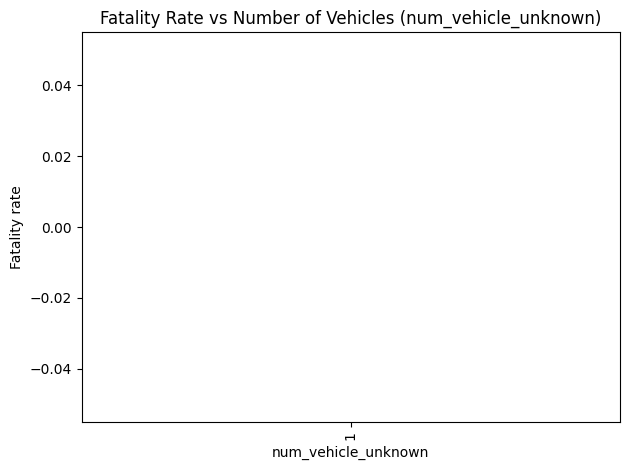

Stats: num_vehicle_pedestrian
                        accidents  fatal  fatality_rate
num_vehicle_pedestrian                                 
1                              12      1       0.083333
2                               1      0       0.000000


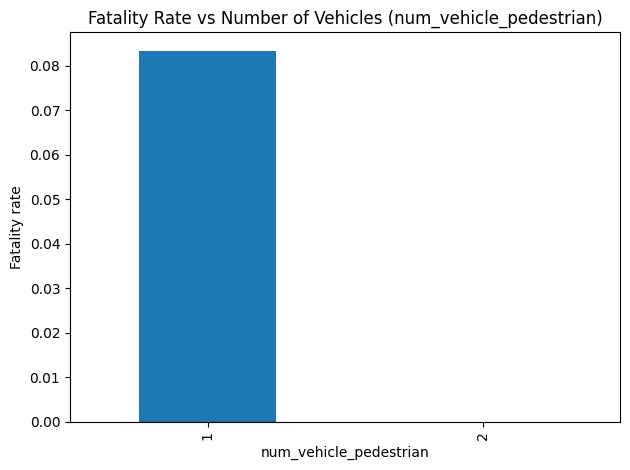

Stats: num_vehicle_bicycle
                     accidents  fatal  fatality_rate
num_vehicle_bicycle                                 
1                            7      1       0.142857


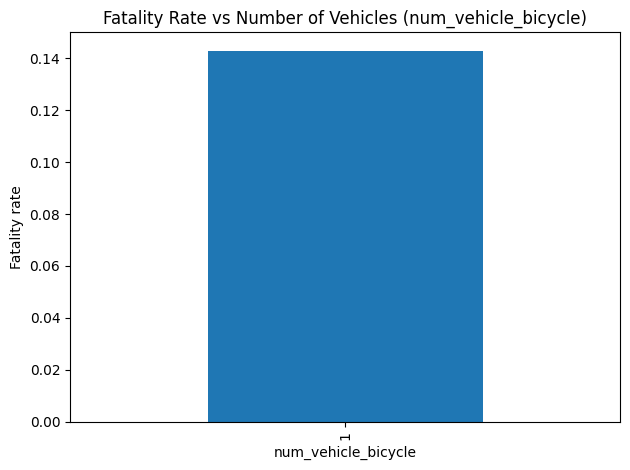

Stats: num_vehicle_motorbike
                       accidents  fatal  fatality_rate
num_vehicle_motorbike                                 
1                             96     12          0.125
2                              4      0          0.000
3                              1      0          0.000


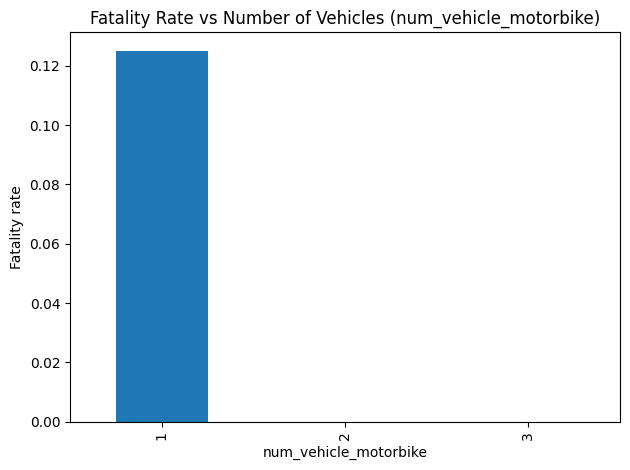

Stats: num_vehicle_car
                 accidents  fatal  fatality_rate
num_vehicle_car                                 
1                      133      9       0.067669
2                       17      4       0.235294
3                        4      2       0.500000


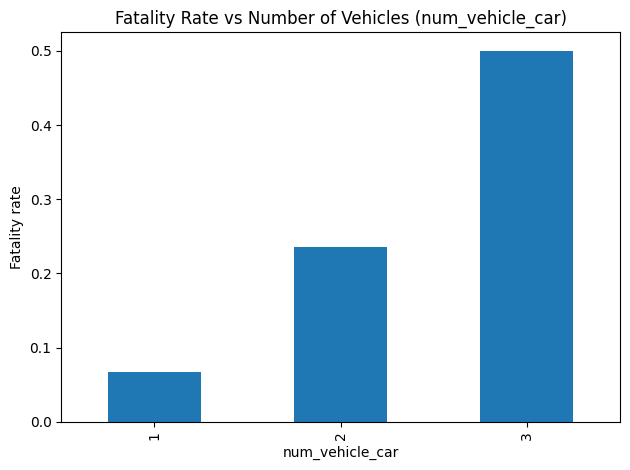

Stats: num_vehicle_van
                 accidents  fatal  fatality_rate
num_vehicle_van                                 
1                       26      3       0.115385
2                        2      1       0.500000


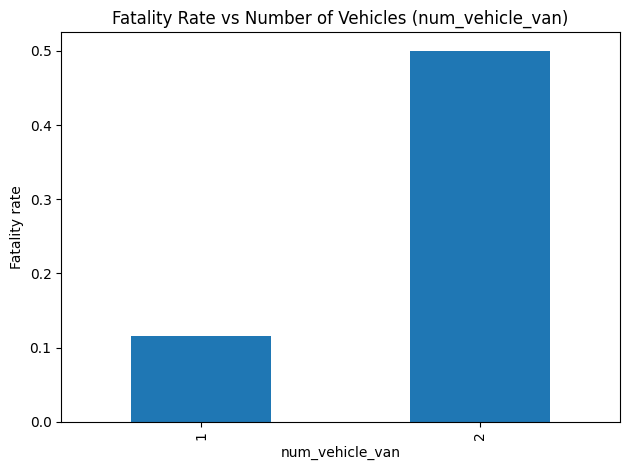

Stats: num_vehicle_bus
                 accidents  fatal  fatality_rate
num_vehicle_bus                                 
1                       11      3       0.272727


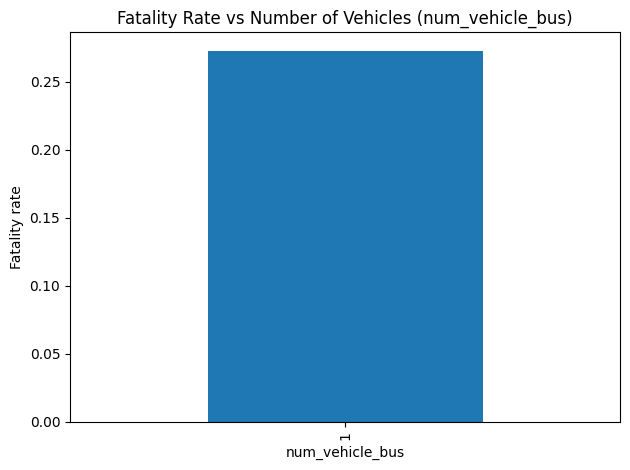

In [17]:
numerical_vehicle_buckets = [
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
]

for col in numerical_vehicle_buckets:
    filtered = df[df[col] > 0]

    if filtered.empty:
        continue # nothing to report

    numeric_vehicle_stats = (
        filtered
        .groupby(col)["is_fatal"]
        .agg(
            accidents="count",
            fatal="sum",
            fatality_rate="mean"
        )
    )

    print(f"Stats: {col}")
    print(numeric_vehicle_stats)

    numeric_vehicle_stats["fatality_rate"].plot(kind="bar")
    plt.title(f"Fatality Rate vs Number of Vehicles ({col})")
    plt.ylabel("Fatality rate")
    plt.tight_layout()
    plt.show()

#### Date Related Columns

Investigating the following columns:

- `is_weekend`
- `is_public_holiday_mt`
- `is_school_holiday_mt`
- `is_school_day_mt`

##### `is_weekend` column

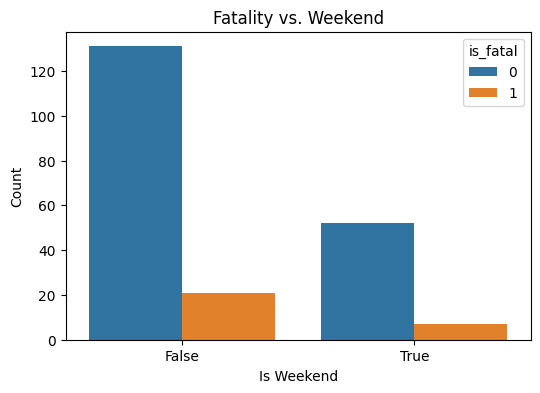

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_weekend', hue='is_fatal')
plt.title('Fatality vs. Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Count')
plt.show()

##### `is_public_holiday_mt` column

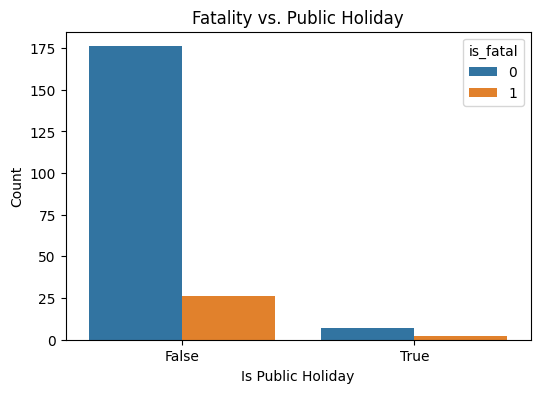

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_public_holiday_mt', hue='is_fatal')
plt.title('Fatality vs. Public Holiday')
plt.xlabel('Is Public Holiday')
plt.ylabel('Count')
plt.show()

##### `is_school_holiday_mt` column

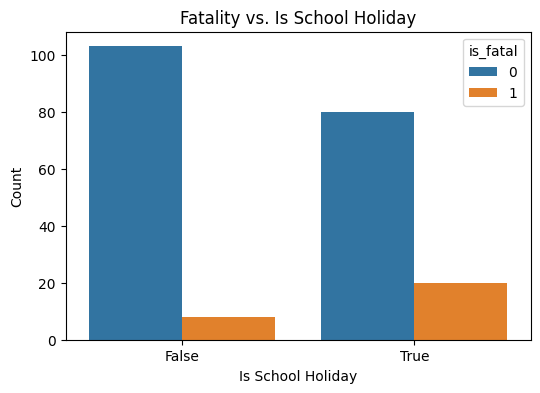

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_school_holiday_mt', hue='is_fatal')
plt.title('Fatality vs. Is School Holiday')
plt.xlabel('Is School Holiday')
plt.ylabel('Count')
plt.show()

Looks like most fatalities happen during periods of school holidays. This could be because big events such as Easter/Christmas are part of this school holiday period and a lot of accidents happen during those times.

##### `is_school_day_mt` column

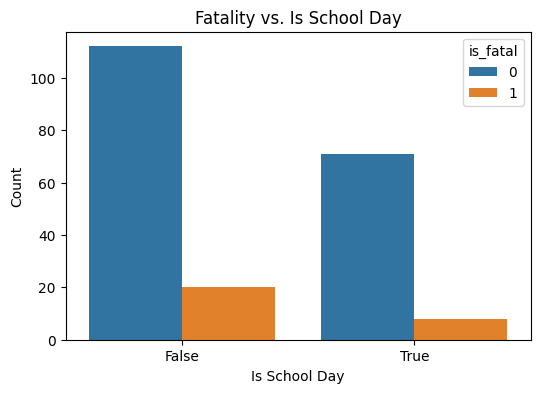

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_school_day_mt', hue='is_fatal')
plt.title('Fatality vs. Is School Day')
plt.xlabel('Is School Day')
plt.ylabel('Count')
plt.show()

As expected, this is an inverse of the previous bar chart (fatality vs. school holidays boolean).

#### Location Related Columns

Investigating the following columns:

- `street_type` column
- `region` column

##### `street_type` column

             non_fatal  fatal  total  fatal_rate
street_type                                     
other                6      3      9    0.333333
primary             29      4     33    0.121212
residential         41      3     44    0.068182
secondary           59      6     65    0.092308
tertiary             8      0      8    0.000000
trunk               40     12     52    0.230769


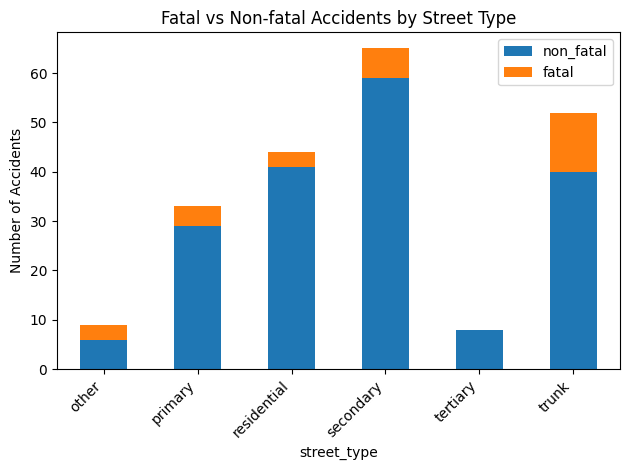

In [22]:
street_type_category_stats = (
    df
    .groupby("street_type")["is_fatal"]
    .value_counts()
    .unstack(fill_value=0)
)

street_type_category_stats.columns = ["non_fatal", "fatal"]

street_type_category_stats["total"] = street_type_category_stats["non_fatal"] + street_type_category_stats["fatal"]
street_type_category_stats["fatal_rate"] = street_type_category_stats["fatal"] / street_type_category_stats["total"]

print(street_type_category_stats)

street_type_category_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Street Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

##### `region` column

                  non_fatal  fatal  total  fatal_rate
region                                               
Central                  49      9     58    0.155172
Gozo                     14      0     14    0.000000
Northern                 53      5     58    0.086207
South Eastern            31      4     35    0.114286
Southern Harbour         36     10     46    0.217391


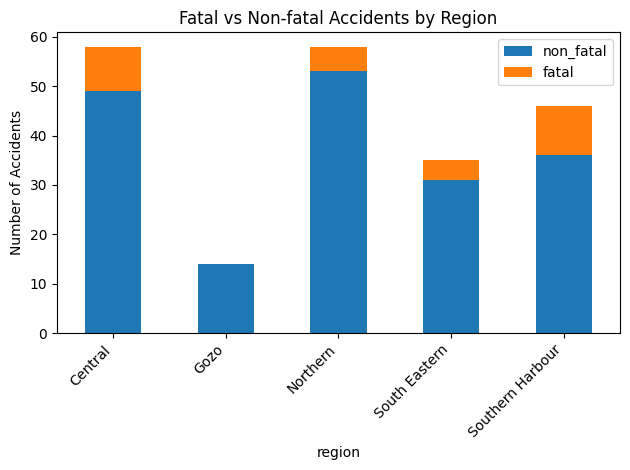

In [23]:
region_category_stats = (
    df
    .groupby("region")["is_fatal"]
    .value_counts()
    .unstack(fill_value=0)
)

region_category_stats.columns = ["non_fatal", "fatal"]

region_category_stats["total"] = region_category_stats["non_fatal"] + region_category_stats["fatal"]
region_category_stats["fatal_rate"] = region_category_stats["fatal"] / region_category_stats["total"]

print(region_category_stats)

region_category_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Temperature Related Columns

Investigating the following columns:

- `temperature_max`
- `temperature_min`
- `temperature_mean`
- `windspeed_max`
- `precipitation_sum`
- `is_raining`

##### `temperature_max` column

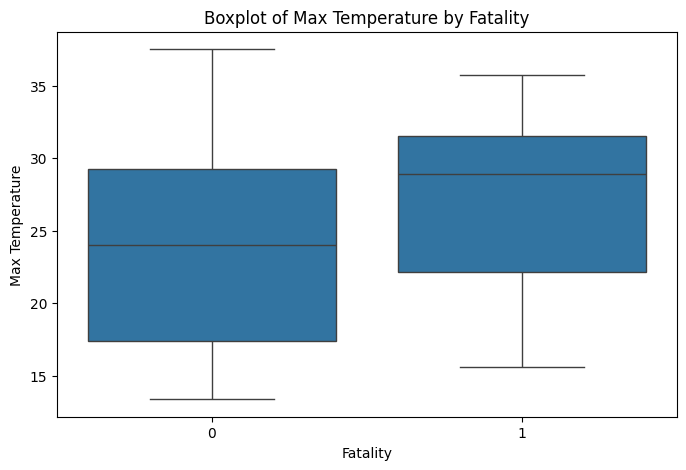

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fatal', y='temperature_max', data=df)
plt.title('Boxplot of Max Temperature by Fatality')
plt.xlabel('Fatality')
plt.ylabel('Max Temperature')
plt.show()

##### `temperature_min` column

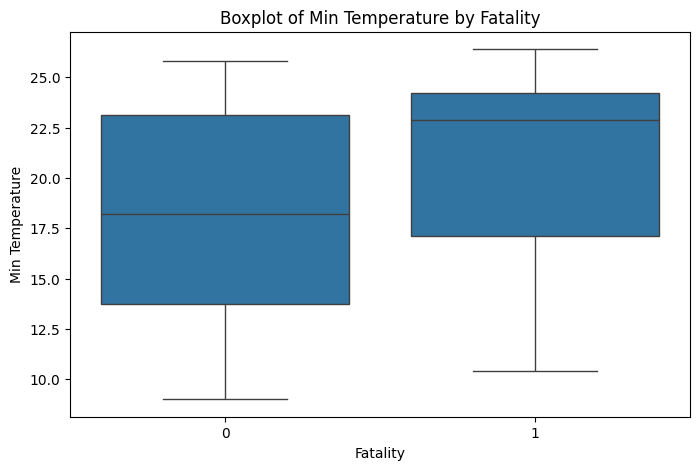

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fatal', y='temperature_min', data=df)
plt.title('Boxplot of Min Temperature by Fatality')
plt.xlabel('Fatality')
plt.ylabel('Min Temperature')
plt.show()

##### `temperature_mean` column

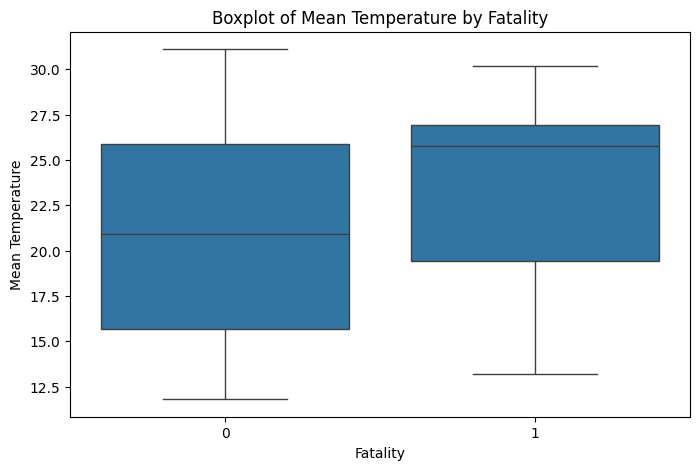

In [26]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fatal', y='temperature_mean', data=df)
plt.title('Boxplot of Mean Temperature by Fatality')
plt.xlabel('Fatality')
plt.ylabel('Mean Temperature')
plt.show()

All temperature columns seem to be highly correlated with each other.

Interestingly as well is that there are more fatalities in higher temperatures.

##### `windspeed_max` column

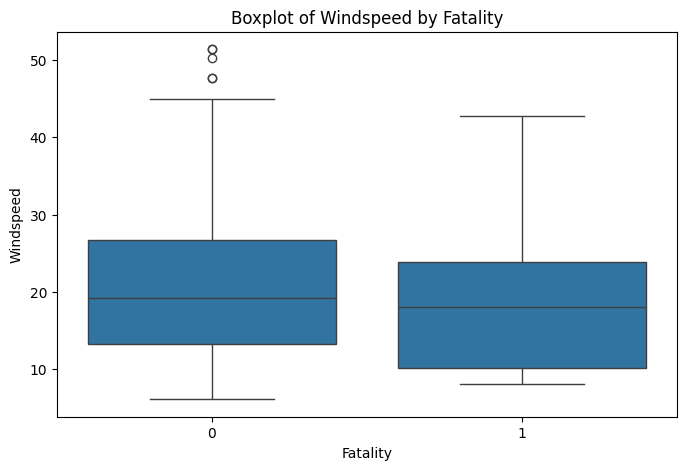

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fatal', y='windspeed_max', data=df)
plt.title('Boxplot of Windspeed by Fatality')
plt.xlabel('Fatality')
plt.ylabel('Windspeed')
plt.show()

##### `precipitation_sum` column

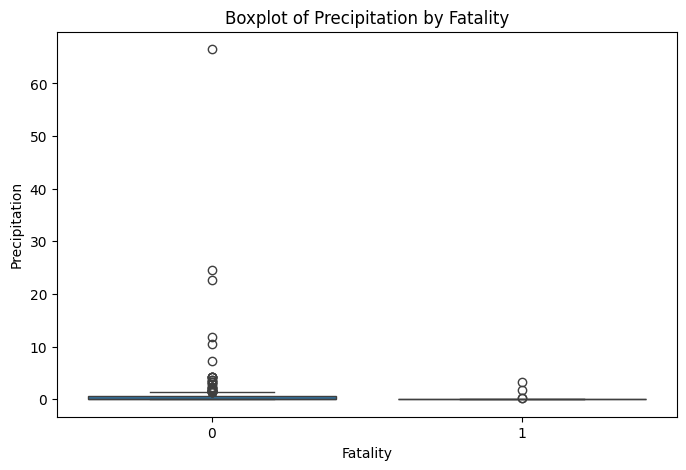

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fatal', y='precipitation_sum', data=df)
plt.title('Boxplot of Precipitation by Fatality')
plt.xlabel('Fatality')
plt.ylabel('Precipitation')
plt.show()

##### `is_raining` column

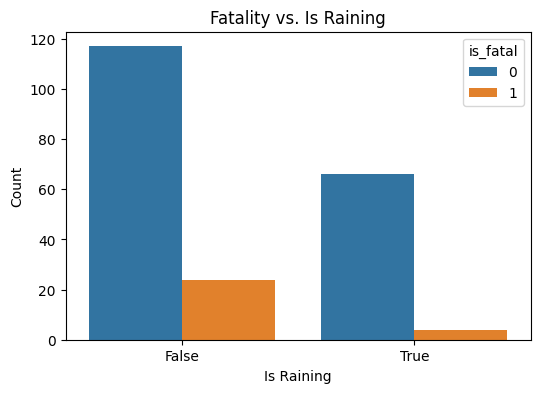

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_raining', hue='is_fatal')
plt.title('Fatality vs. Is Raining')
plt.xlabel('Is Raining')
plt.ylabel('Count')
plt.show()

As expected, both precipitation and is raining charts are similar.

Interestingly enough, raining seems to be inversely correleated with fatal accidents. It might be that drivers are more careful when it rains. Moreover, in Malta there is not a lot of rain throughout the year so fewer accidents in the rain happen.

#### Traffic Level Column

Investigate the `traffic_level` column.

               non_fatal  fatal  total  fatal_rate
traffic_level                                     
HEAVY                  5      0      5    0.000000
LOW                  150     25    175    0.142857
MODERATE              28      3     31    0.096774


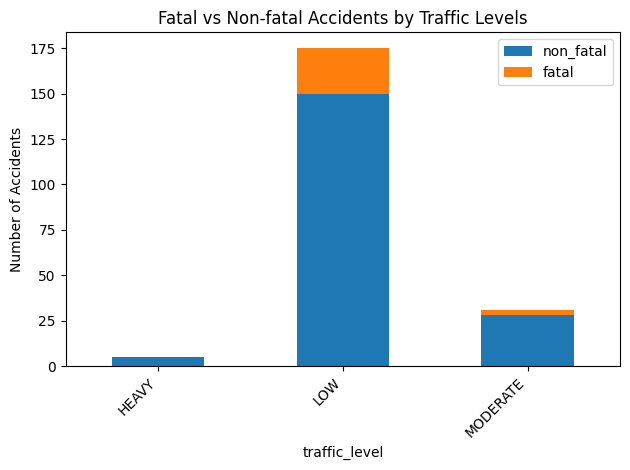

In [30]:
traffic_level_stats = (
    df
    .groupby("traffic_level")["is_fatal"]
    .value_counts()
    .unstack(fill_value=0)
)

traffic_level_stats.columns = ["non_fatal", "fatal"]

traffic_level_stats["total"] = traffic_level_stats["non_fatal"] + traffic_level_stats["fatal"]
traffic_level_stats["fatal_rate"] = traffic_level_stats["fatal"] / traffic_level_stats["total"]

print(traffic_level_stats)

traffic_level_stats[["non_fatal", "fatal"]].plot(
    kind="bar",
    stacked=True
)

plt.ylabel("Number of Accidents")
plt.title("Fatal vs Non-fatal Accidents by Traffic Levels")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

It's expected that in HEAVY traffic we don't have fatal accidents because vehicles are usually driving slower. However, it seems that most of the accidents have happened in LOW traffic situations.

This could mean either of two things:

1. Accidents that caught attention of the media/police press releases are usually severe accidents. For a severe accident to happen, drivers/vehicles must be going at a certain speed, which usually means that there is no traffic in the error.
2. Issues with the `traffic_level` data collection process. 

### Check for correlation

Checking for correlation on the numerical/boolean variables.

In [31]:
df_numeric = df[[
    #"accident_time_category",
    "driver_under_18",
    "driver_18_to_24",
    "driver_25_to_49",
    "driver_50_to_64",
    "driver_65_plus",
    "driver_age_unknown",
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "driver_male",
    "driver_female",
    "driver_gender_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
    "num_drivers_total",
    "vehicle_unknown",
    "vehicle_pedestrian",
    "vehicle_bicycle",
    "vehicle_motorbike",
    "vehicle_car",
    "vehicle_van",
    "vehicle_bus",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
    "is_weekend",
    "is_public_holiday_mt",
    "is_school_holiday_mt",
    "is_school_day_mt",
    #"street_type",
    #"region",
    "temperature_max",
    "temperature_min",
    "temperature_mean",
    "windspeed_max",
    "precipitation_sum",
    "is_raining",
    "traffic_level",
    "is_fatal",
]]

df_numeric["traffic_level"] = df["traffic_level"].map(
    lambda x: 0 if x == 'LOW' else (1 if x == 'MODERATE' else 2)
)

df_numeric

,driver_under_18,driver_18_to_24,driver_25_to_49,driver_50_to_64,driver_65_plus,driver_age_unknown,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,...,is_school_holiday_mt,is_school_day_mt,temperature_max,temperature_min,temperature_mean,windspeed_max,precipitation_sum,is_raining,traffic_level,is_fatal
8,False,False,False,False,False,True,0,0,0,0,...,False,False,19.8,12.1,16.0,20.9,0.0,False,0,0
9,False,False,True,False,False,True,0,0,1,0,...,False,True,26.5,20.8,23.5,22.7,7.3,True,0,0
10,False,False,False,False,True,True,0,0,0,0,...,False,True,19.5,14.7,17.6,21.9,1.1,True,1,0
11,False,False,True,False,False,False,0,0,1,0,...,False,True,18.0,12.1,14.9,9.9,0.0,False,0,0
12,False,False,False,True,False,False,0,0,0,1,...,False,True,18.4,12.5,15.4,9.9,0.0,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,False,False,False,False,True,False,0,0,0,0,...,False,True,23.4,20.0,22.2,35.9,0.3,True,0,0
215,False,False,False,False,False,True,0,0,0,0,...,False,True,24.3,17.9,21.1,9.8,0.0,False,0,0
216,False,False,False,True,True,False,0,0,0,1,...,False,True,23.8,17.4,20.6,9.8,0.0,False,0,0
217,False,False,False,False,False,True,0,0,0,0,...,False,True,24.5,18.1,21.2,6.7,0.0,False,0,0


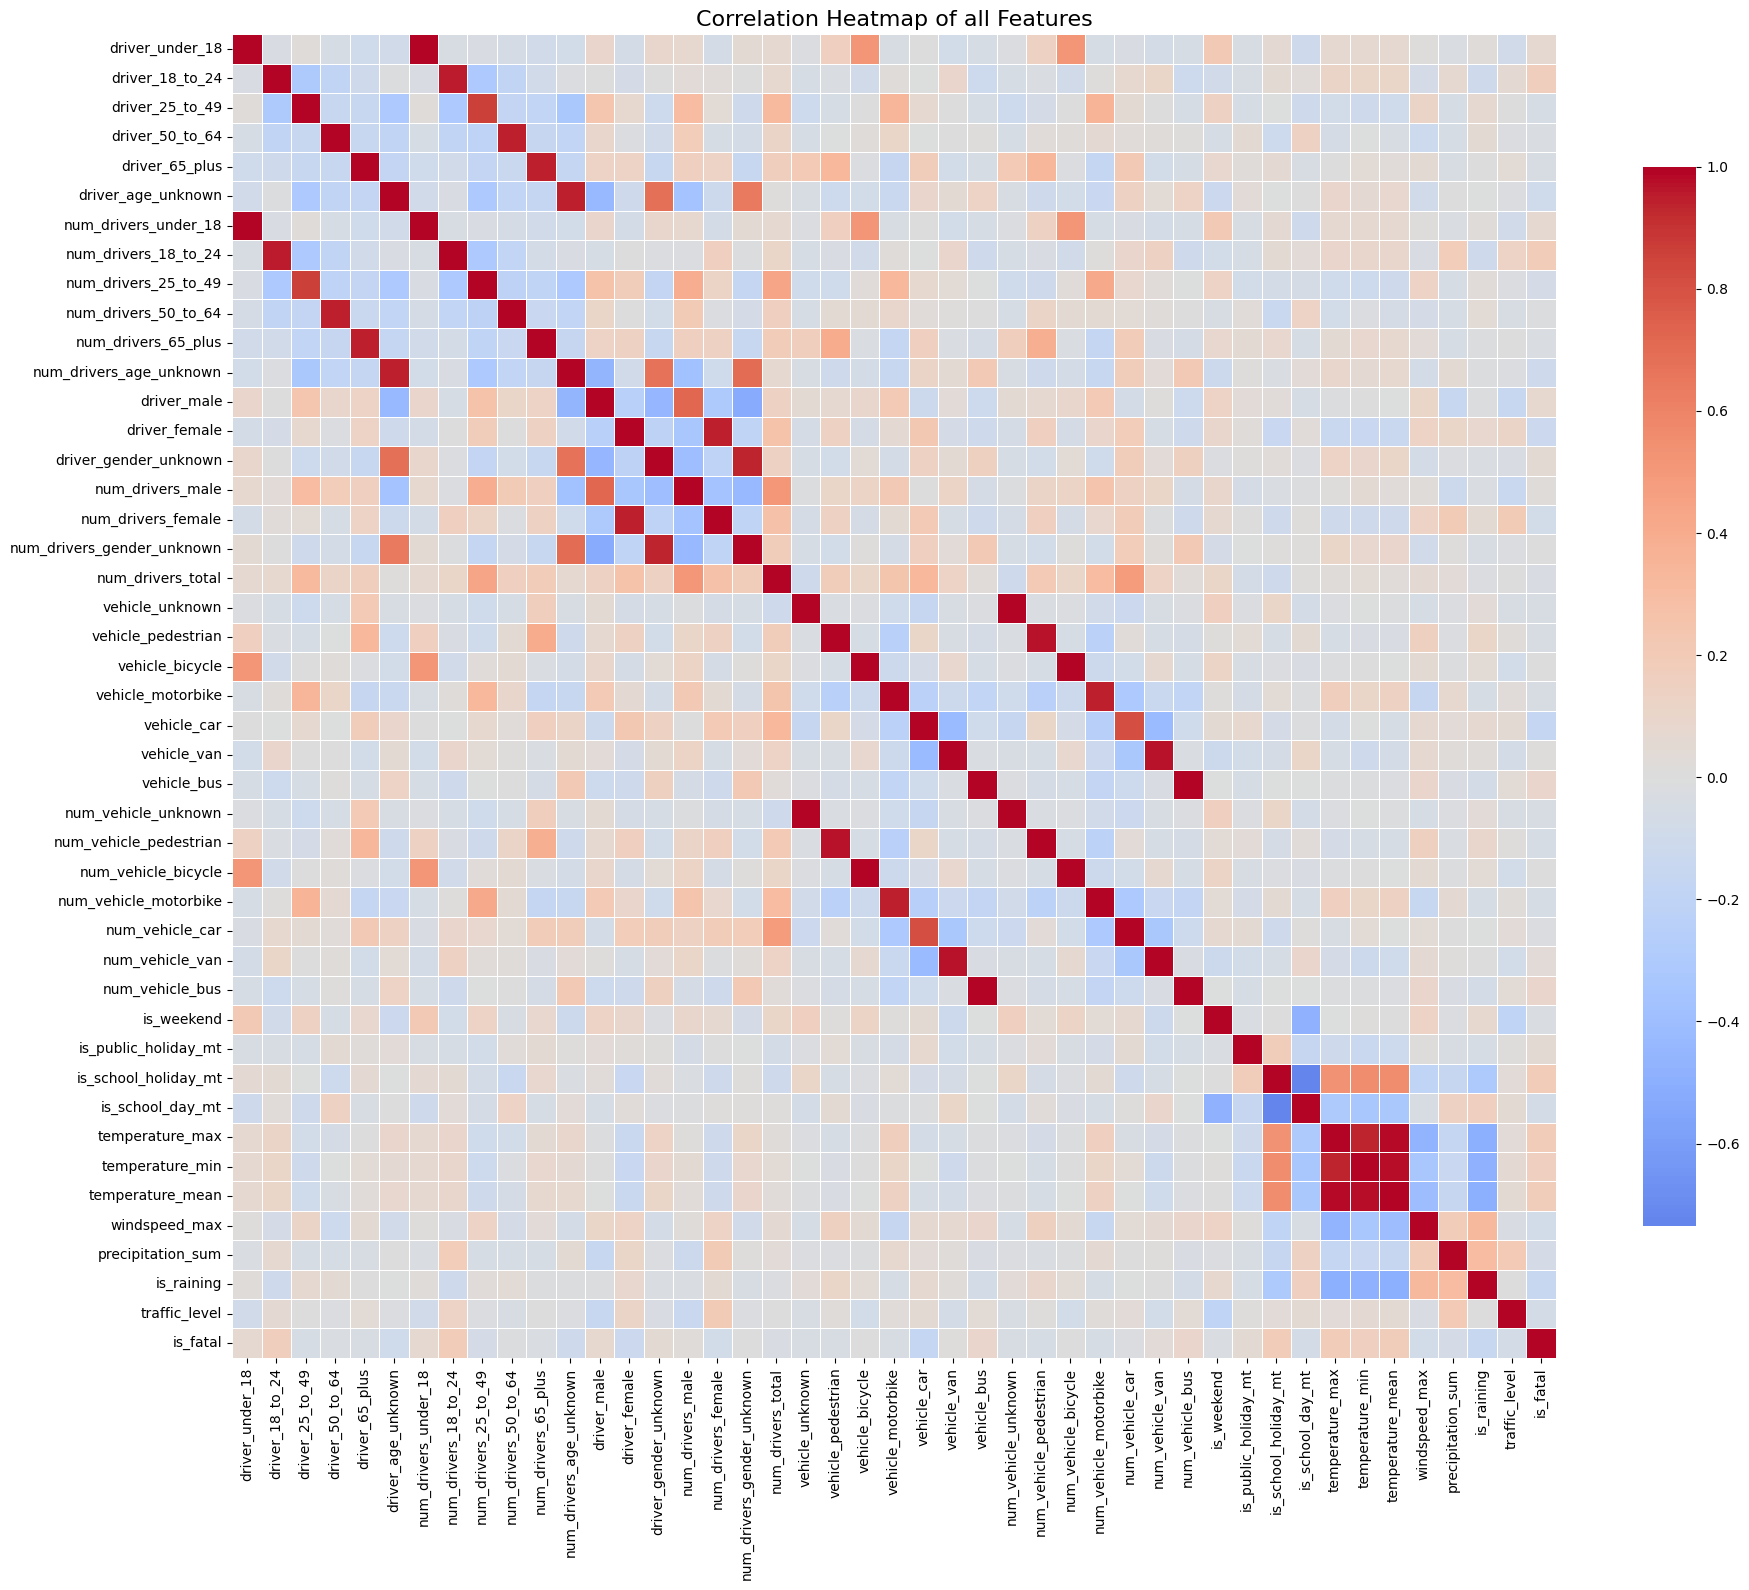

In [32]:
# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot correlation heatmap (top features)
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of all Features', fontsize=16)
plt.tight_layout()
plt.show()

Based on this correlation chart, the numerical and categorical values for vehicle/driver gender/driver ages are highly correleated with one another. Hence, let's take only the numerical representations.

Similarly, there's high correleation between the temperature columns, so we onnly will pick the mean.

In [33]:
accident_time_categories_df = pd.get_dummies(df["accident_time_category"], drop_first=True, dtype=int)
accident_time_categories_df

,early_morning,evening,late_evening,morning,night
8,0,0,0,0,1
9,0,0,0,0,1
10,0,0,0,0,0
11,0,0,0,1,0
12,0,0,0,0,0
...,...,...,...,...,...
214,0,0,0,1,0
215,0,0,0,0,1
216,0,0,0,1,0
217,0,0,0,0,0


In [34]:
street_type_categories_df = pd.get_dummies(df["street_type"], drop_first=True, dtype=int)
street_type_categories_df

,primary,residential,secondary,tertiary,trunk
8,1,0,0,0,0
9,0,1,0,0,0
10,0,0,0,0,1
11,0,1,0,0,0
12,0,0,0,0,1
...,...,...,...,...,...
214,0,1,0,0,0
215,0,0,0,0,0
216,1,0,0,0,0
217,0,0,0,0,1


In [35]:
region_categories_df = pd.get_dummies(df["region"], drop_first=True, dtype=int)
region_categories_df

,Gozo,Northern,South Eastern,Southern Harbour
8,0,0,0,0
9,0,1,0,0
10,0,1,0,0
11,0,1,0,0
12,0,1,0,0
...,...,...,...,...
214,0,1,0,0
215,0,0,0,1
216,0,0,1,0
217,0,0,0,1


### Feature Selection

In [36]:
final_df = df[[
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
    "is_weekend",
    "is_school_holiday_mt", # select only this as it is correleated with public holiday/school day booleans
    "temperature_mean", # select only this as highly correleated with other temperature columns
    "is_raining",
    "is_fatal", # target variable
]].join(
    accident_time_categories_df
).join(
    street_type_categories_df
).join(
    region_categories_df
)

final_df["is_weekend"] = final_df['is_weekend'].astype(int)
final_df["is_school_holiday_mt"] = final_df['is_school_holiday_mt'].astype(int)
final_df["is_raining"] = final_df['is_raining'].astype(int)

print("DataFrame before scaling:")
display(final_df)

columns_to_scale = [
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
    "temperature_mean",
]

scaler = StandardScaler()
final_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("DataFrame after scaling:")
display(final_df)

print("Dataset information:")    
final_df.info()

DataFrame before scaling:


,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,num_drivers_gender_unknown,num_vehicle_unknown,...,night,primary,residential,secondary,tertiary,trunk,Gozo,Northern,South Eastern,Southern Harbour
8,0,0,0,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
9,0,0,1,0,0,1,2,0,0,0,...,1,0,1,0,0,0,0,1,0,0
10,0,0,0,0,1,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
11,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
12,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0,0,0,0,2,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
215,0,0,0,0,0,2,0,0,2,0,...,1,0,0,0,0,0,0,0,0,1
216,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
217,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


DataFrame after scaling:


,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,num_drivers_gender_unknown,num_vehicle_unknown,...,night,primary,residential,secondary,tertiary,trunk,Gozo,Northern,South Eastern,Southern Harbour
8,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,1.706497,-1.530428,1.304785,-0.466381,-0.097823,...,1,1,0,0,0,0,0,0,0,0
9,-0.198517,-0.462876,0.344694,-0.535974,-0.452432,1.706497,1.253368,-0.607087,-0.466381,-0.097823,...,1,0,1,0,0,0,0,1,0,0
10,-0.198517,-0.462876,-0.977677,-0.535974,1.717184,1.706497,-0.138530,-0.607087,1.463156,-0.097823,...,0,0,0,0,0,1,0,1,0,0
11,-0.198517,-0.462876,0.344694,-0.535974,-0.452432,-0.411567,-1.530428,1.304785,-0.466381,-0.097823,...,0,0,1,0,0,0,0,1,0,0
12,-0.198517,-0.462876,-0.977677,1.448070,-0.452432,-0.411567,-0.138530,-0.607087,-0.466381,-0.097823,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.198517,-0.462876,-0.977677,-0.535974,3.886800,-0.411567,-0.138530,1.304785,-0.466381,-0.097823,...,0,0,1,0,0,0,0,1,0,0
215,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,3.824561,-1.530428,-0.607087,3.392694,-0.097823,...,1,0,0,0,0,0,0,0,0,1
216,-0.198517,-0.462876,-0.977677,1.448070,1.717184,-0.411567,-0.138530,1.304785,-0.466381,-0.097823,...,0,1,0,0,0,0,0,0,1,0
217,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,1.706497,-1.530428,-0.607087,1.463156,-0.097823,...,0,0,0,0,0,1,0,0,0,1


Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 8 to 218
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_drivers_under_18        211 non-null    float64
 1   num_drivers_18_to_24        211 non-null    float64
 2   num_drivers_25_to_49        211 non-null    float64
 3   num_drivers_50_to_64        211 non-null    float64
 4   num_drivers_65_plus         211 non-null    float64
 5   num_drivers_age_unknown     211 non-null    float64
 6   num_drivers_male            211 non-null    float64
 7   num_drivers_female          211 non-null    float64
 8   num_drivers_gender_unknown  211 non-null    float64
 9   num_vehicle_unknown         211 non-null    float64
 10  num_vehicle_pedestrian      211 non-null    float64
 11  num_vehicle_bicycle         211 non-null    float64
 12  num_vehicle_motorbike       211 non-null    float64
 13  num_vehicle_car    

## SVM Training

Let's train different SVMs and see how our models performs on the features selected.

Helpful resources:
1. https://www.kaggle.com/code/prashant111/svm-classifier-tutorial
2. https://www.kaggle.com/code/rajeev102001/svm-support-vector-machine-for-classification
3. https://www.geeksforgeeks.org/machine-learning/optimal-feature-selection-for-support-vector-machines/

In [37]:
X = final_df.drop(["is_fatal"], axis=1)
y = final_df["is_fatal"]

In [38]:
# use stratify to make sure that target variable distribution between train/test sets are not imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

print("Training set distribution:")
print(y_train.value_counts())
print("\nTesting set distribution:")
print(y_test.value_counts())

# Relative distribution (percentages)
print("\nTraining set distribution (percent):")
print(y_train.value_counts(normalize=True) * 100)
print("\nTesting set distribution (percent):")
print(y_test.value_counts(normalize=True) * 100)

Training set distribution:
is_fatal
0    146
1     22
Name: count, dtype: int64

Testing set distribution:
is_fatal
0    37
1     6
Name: count, dtype: int64

Training set distribution (percent):
is_fatal
0    86.904762
1    13.095238
Name: proportion, dtype: float64

Testing set distribution (percent):
is_fatal
0    86.046512
1    13.953488
Name: proportion, dtype: float64


### Baseline

Let's use the null accuracy as a baseline metric. Null accuracy in machine learning is a baseline metric representing the accuracy achieved by always predicting the most frequent class in a dataset. It serves as a benchmark for evaluating classification models, specifically in imbalanced datasets where a "naive" model might otherwise seem highly accurate.

In [39]:
# calculate null accuracy on test set
null_acc_test = y_test.value_counts().max() / len(y_test)
print(f"Null accuracy value: {null_acc_test}. Achieved by assigning all instances in the test set to the class that has the highest frequency (in this case, the non-fatal class).")

Null accuracy value: 0.8604651162790697. Achieved by assigning all instances in the test set to the class that has the highest frequency (in this case, the non-fatal class).


### SVM with default hyperparameters

Default hyperparameter means C=1.0, kernel=`rbf` and gamma=`auto` among other parameters.

In [40]:
# instantiate classifier with default hyperparameters
svc=SVC() 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.8837


### Try with different regularisation (C) values

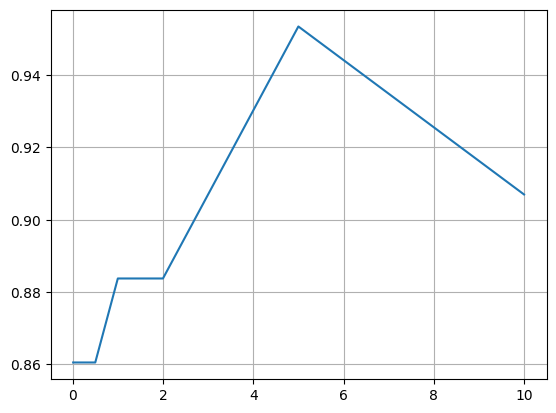

In [41]:
regularisation = [0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
performance = []

for C in regularisation:
    svc = SVC(C=C, kernel='rbf')
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    performance.append(accuracy)

plt.plot(regularisation, performance)
plt.grid(True)

Choose the best C, which is 5.

In [42]:
svc=SVC(C=5, kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9535


### Evaluation Metrics

In [43]:
for i, pred in enumerate(y_pred):
    actual = y_test.iloc[i]
    print(f"Prediction Number: {i + 1}. Predicted: {pred}. Actual: {actual}")

Prediction Number: 1. Predicted: 0. Actual: 0
Prediction Number: 2. Predicted: 0. Actual: 0
Prediction Number: 3. Predicted: 0. Actual: 0
Prediction Number: 4. Predicted: 0. Actual: 0
Prediction Number: 5. Predicted: 0. Actual: 0
Prediction Number: 6. Predicted: 0. Actual: 0
Prediction Number: 7. Predicted: 0. Actual: 0
Prediction Number: 8. Predicted: 0. Actual: 0
Prediction Number: 9. Predicted: 0. Actual: 0
Prediction Number: 10. Predicted: 0. Actual: 0
Prediction Number: 11. Predicted: 0. Actual: 0
Prediction Number: 12. Predicted: 0. Actual: 0
Prediction Number: 13. Predicted: 1. Actual: 1
Prediction Number: 14. Predicted: 0. Actual: 0
Prediction Number: 15. Predicted: 0. Actual: 0
Prediction Number: 16. Predicted: 0. Actual: 0
Prediction Number: 17. Predicted: 0. Actual: 0
Prediction Number: 18. Predicted: 0. Actual: 0
Prediction Number: 19. Predicted: 0. Actual: 0
Prediction Number: 20. Predicted: 0. Actual: 0
Prediction Number: 21. Predicted: 0. Actual: 0
Prediction Number: 22.

In [44]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

print('Confusion matrix:', cm)

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

print('True Positives(TP) = ', TP)
print('True Negatives(TN) = ', TN)
print('False Positives(FP) = ', FP)
print('False Negatives(FN) = ', FN)

Confusion matrix: [[ 4  2]
 [ 0 37]]
True Positives(TP) =  4
True Negatives(TN) =  37
False Positives(FP) =  2
False Negatives(FN) =  0


<Axes: >

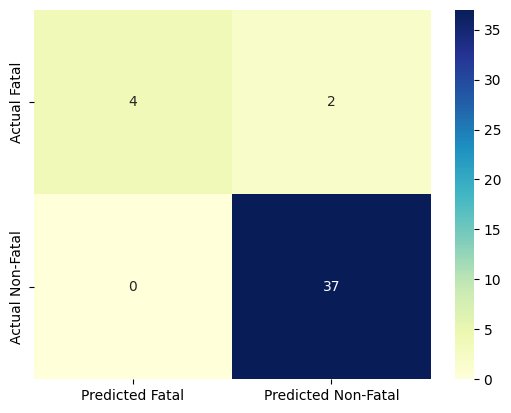

In [45]:
cm_matrix = pd.DataFrame(
    cm,
    index=['Actual Fatal', 'Actual Non-Fatal'],
    columns=['Predicted Fatal', 'Predicted Non-Fatal']
)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [46]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / (TN + FP)
f1_score = (2 * precision * recall) / (precision + recall)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
print('Classification error : {0:0.4f}'.format(classification_error))
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('Specificity : {0:0.4f}'.format(specificity))
print('F1 Score : {0:0.4f}'.format(f1_score))

Classification accuracy : 0.9535
Classification error : 0.0465
Precision : 0.6667
Recall or Sensitivity : 1.0000
Specificity : 0.9487
F1 Score : 0.8000


### To-do: Cleanup cells below.

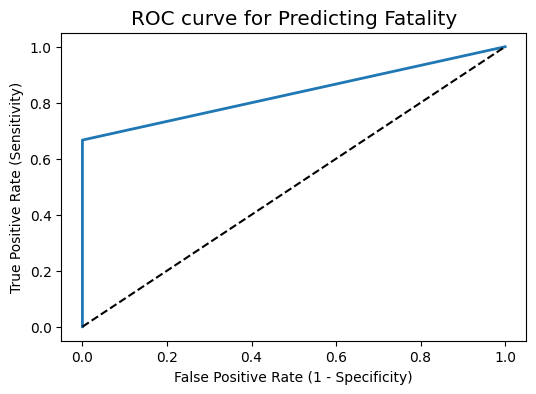

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Fatality')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [48]:
from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8333
